# IT00CJ11 Computer Vision (5 cr. ECTS), spring 2022

***Direct computational methods and deep learning for vision***

***Multiple view geometry***

In this notebook, we will consider how to handle multiple views and how to use the geometric relationships between them to recover camera positions and 3D structure. With images taken at different view points, it is possible to compute 3D scene points as well as camera locations from feature matches. (Picture below from Wikipedia).

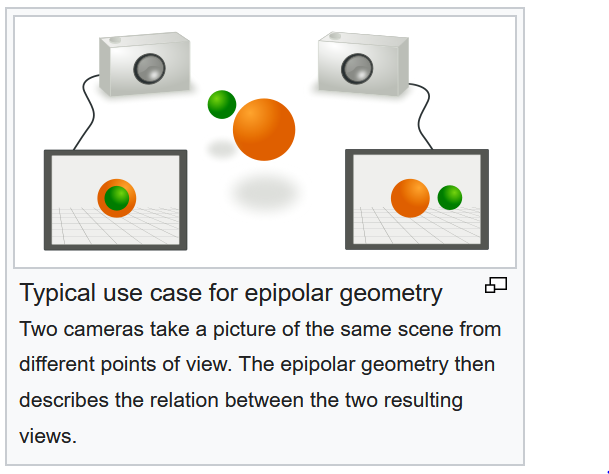

*Epipolar geometry*

Multiple view geometry is the field studying the relationship between cameras and features when there are correspondences between many images that are taken from varying viewpoints. The image features are usually interest points, and we will focus on that case throughout this chapter. The most important constellation is two-view geometry.

With two views of a scene and corresponding points in these views, there are geometric constraints on the image points as a result of the relative orientation of the cameras, the properties of the cameras, and the position of the 3D points. These geometric relationships are described by what is called epipolar geometry. This section will give a very short description of the basic components we need.

Without any prior knowledge of the cameras, there is an inherent ambiguity in that a 3D point, $\mathbf{X}$, transformed with an arbitrary ($4 \times 4$) homography $H$ as $H \mathbf{X}$ will have the same image point in a camera $P H^{−1}$ as the original point in the camera $P$. Expressed with the camera equation, this is

$$\lambda \mathbf{x} = P \mathbf{X} = P H^{-1} H \mathbf{X} = \hat{P} \hat{\mathbf{X}}$$

Because of this ambiguity, when analyzing two view geometry we can always transform the cameras with a homography to simplify matters. Often this homography is just a rigid transformation to change the coordinate system. A good choice is to set the origin and coordinate axis to align with the first camera so that

$$P_1 = K_1 \left( \begin{array}{ccc} I & | & \mathbf{0} \end{array} \right) \ \ \text{and} \ \ 
P_2 = K_2 \left( \begin{array}{ccc} R & | & \mathbf{t} \end{array} \right) \ .$$

Here we use the same notation as in previous notebooks; $K_1$ and $K_2$ are the calibration matrices, $R$ is the rotation of the second camera, and $\mathbf{t}$ is the translation of the second camera. Using these camera matrices, one can derive a condition for the projection of a point $\mathbf{X}$ to image points $\mathbf{x}_1$ and $\mathbf{x}_2$ (with $P_1$ and $P_2$, respectively). This condition is what makes it possible to recover the camera matrices from corresponding image points.

The following equation is called *the epipolar constraint* and must be satisfied:

$$\mathbf{x}_2^{\mathrm{T}} F \mathbf{x}_1 = 0 \ ,$$

where

$$F = \left( K_2^{\mathrm{T}} \right)^{-1} S_{\mathbf{t}} R K_1^{-1} \ ,$$

and $S_{\mathbf{t}}$ is the skew-symmetric matrix:

$$S_{\mathbf{t}} = \left( \begin{array}{ccc} 0 & -t_3 & t_2 \\ t_3 & 0 & -t_1 \\ -t_2 & t_1 & 0 \end{array} \right)$$

The matrix $F$ in the epipolar constraint is called the fundamental matrix and as you can see, it is expressed in components of the two camera matrices (their relative rotation $R$ and translation $\mathbf{t}$). The fundamental matrix has rank 2 and $\det{(F )} = 0$. This will be used in algorithms for estimating $F$. 

The equations above mean that the camera matrices can be recovered from $F$, which in turn can be computed from point correspondences, as we will see later. Without knowing the internal calibration ($K_1$ and $K_2$), the camera matrices are only recoverable up to a projective transformation. With known calibration, the reconstruction will be metric. A metric reconstruction is a 3D reconstruction that correctly represents distances and angles.


There is one final piece of geometry needed before we can proceed to actually using this theory on some image data. Given a point in one of the images, for example $\mathbf{x}_2$ in the second view, the epipolar constraint defines a line in the first image since

$$\underbrace{ \mathbf{x}_2^{\mathrm{T}} F }_{l_1^{\mathrm{T}}} \mathbf{x}_1 = 0 \ ,$$

The equation $l_1^{\mathrm{T}} \mathbf{x}_1 = 0$ determines a line with all points $\mathbf{x}_1$ in the first image satisfying the equation belonging to the line. This line is called an epipolar line corresponding
to the point $\mathbf{x}_1$. This means that a corresponding point to $\mathbf{x}_2$ must lie on this line. The
fundamental matrix can therefore help the search for correspondences by restricting the search to this line.

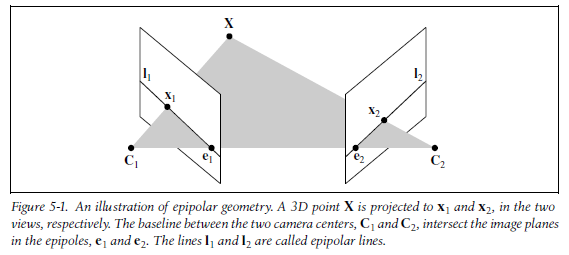

The epipolar lines all meet in a point, $\mathbf{e}$, called the epipole. The epipole is actually the image point corresponding to the projection of the other camera center. This point can be outside the actual image, depending on the relative orientation of the cameras. Since the epipole lies on all epipolar lines, it must satisfy $F \mathbf{e}_1 = 0$. It can, therefore, be computed as the null vector of $F$, as we will see later. The other epipole can be computed from the relation $\mathbf{e}_2^{\mathrm{T}} F = 0$. The epipoles and the epipolar lines are illustrated in Figure 5-1.

*A sample data set*

In what follows, we will need a data set with image points, 3D points, and camera matrices to experiment with and illustrate the algorithms. We will use one of the sets from the Oxford multi-view datasets available at https://www.robots.ox.ac.uk/~vgg/data/mview/ . Download the zipped file for the Merton1 data. The following script will load all the data for you:

In [257]:
from PIL import Image
import numpy as np
from pylab import *
import camera
# load some images
im1 = array(Image.open('images/001.jpg'))
im2 = array(Image.open('images/002.jpg'))

# load 2D points for each view to a list
points2D = [loadtxt('2D/00'+str(i+1)+'.corners').T for i in range(3)]

# load 3D points
points3D = loadtxt('3D/p3d').T

# load correspondences
corr = np.genfromtxt('2D/nview-corners',dtype='int',missing_values='*')

# load cameras to a list of Camera objects
P = [camera.Camera(loadtxt('2D/00'+str(i+1)+'.P')) for i in range(3)]

This will load the first two images (out of three), all the image feature points for the three views, the reconstructed 3D points corresponding to the image points, which points correspond across views, and finally the camera matrices (where we used the Camera class from the previous notebook, it is found in the notebook directory). Here we used loadtxt() to read the text files to NumPy arrays. The correspondences contain missing data, since not all points are visible or successfully matched in all views. The correspondences need to be loaded with this taken into account. The function genfromtxt() solves this by replacing the missing values (denoted with ‘*’ in this file) with −1.

Let’s see what this data looks like. Try to project the 3D points into one view and compare the results with the observed image points:

(-0.5, 1023.5, 767.5, -0.5)

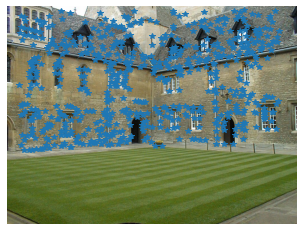

In [258]:
# make 3D points homogeneous and project
X = vstack( (points3D,ones(points3D.shape[1])) )
x = P[0].project(X)

# plotting the points in view 1
figure()
imshow(im1)
plot(points2D[0][0],points2D[0][1],'*')
axis('off')

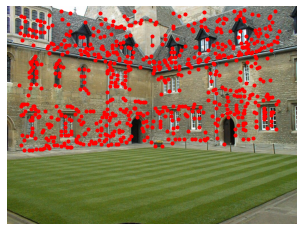

In [259]:
figure()
imshow(im1)
plot(x[0],x[1],'r.')
axis('off')
show()

This creates a plot with the first view and image points in that view; for comparison, the projected points are shown in a separate figure. If you look closely, you will see that the second plot with the projected 3D points contains more points than the first. These are image feature points reconstructed from view 2 and 3 but not detected in view 1.

*Plotting 3D Data with Matplotlib*

To visualize our 3D reconstructions, we need to be able to plot in 3D. The mplot3d toolkit in Matplotlib provides 3D plotting of points, lines, contours, surfaces and most other basic plotting components as well as 3D rotation and scaling from the controls of the figure window.

Making a plot in 3D is done by adding the projection="3d" keyword to the axes object like this:

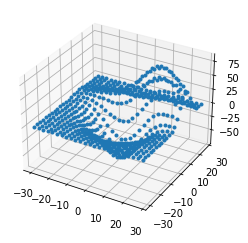

In [260]:
from mpl_toolkits.mplot3d import axes3d
fig = figure()
ax = plt.axes(projection="3d")
# ax = fig.gca(projection='3d') - outdated -
# generate 3D sample data
X,Y,Z = axes3d.get_test_data(0.25)
# plot the points in 3D
ax.plot(X.flatten(),Y.flatten(),Z.flatten(),'.')
show()

The function get_test_data() generates sample points on a regular x, y grid with the parameter determining the spacing. Flattening these grids gives three lists of points that can be sent to plot(). This should plot 3D points on what looks like a surface. Try it out and see for yourself.

Now we can plot the Merton sample data to see what the 3D points look like:

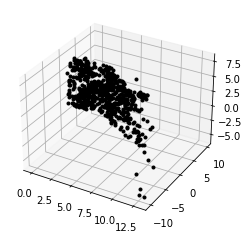

In [261]:
# plotting 3D points
from mpl_toolkits.mplot3d import axes3d
fig = figure()
ax = plt.axes(projection="3d")
# ax = fig.gca(projection='3d') - outdated -
ax.plot(points3D[0],points3D[1],points3D[2],'k.')

Figure 5-3 in Solem shows the 3D points from three different views. The figure window and controls look like the standard plot windows for images and 2D datawith an additional 3D rotation tool.

*Computing $F$ — The Eight Point Algorithm*

The eight point algorithm is an algorithm for computing the fundamental matrix from point correspondences. Here’s a brief description:

The epipolar constraint can be written as the linear system

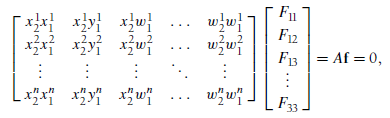

where $\mathbf{f}$ contains the elements of $F$, the vectors

$$\mathbf{x}_1^i = \left( \begin{array}{ccc} x_1^i & y_1^i & w_1^i \end{array} \right) \ \
\text{and} \ \ \mathbf{x}_2^i = \left( \begin{array}{ccc} x_2^i & y_2^i & w_2^i \end{array} \right)$$

make up a correspondence pair, and there are $n$ point correspondences in total. The fundamental matrix has nine elements, but since the scale is arbitrary, only eight equations are needed. Eight point correspondences are therefore needed to compute $F$; hence the name of the algorithm.

The following function for the eight point algorithm minimizes $\left\| A f \right\|$:

In [262]:
def compute_fundamental(x1,x2):
    """    Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the 8 point algorithm.
        Each row in the A matrix below is constructed as
        [x'*x, x'*y, x', y'*x, y'*y, y', x, y, 1] """
    
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")
    
    # build matrix for equations
    A = zeros((n,9))
    for i in range(n):
        A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i]*x2[2,i],
                x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i]*x2[2,i],
                x1[2,i]*x2[0,i], x1[2,i]*x2[1,i], x1[2,i]*x2[2,i] ]
            
    # compute linear least square solution
    U,S,V = linalg.svd(A)
    F = V[-1].reshape(3,3)
        
    # constrain F
    # make rank 2 by zeroing out last singular value
    U,S,V = linalg.svd(F)
    S[2] = 0
    F = dot(U,dot(diag(S),V))
    
    return F/F[2,2]

As usual, we compute the least squares solution using SVD. Since the resulting solution might not have rank 2 as a proper fundamental matrix should, we replace the result with the closest rank 2 approximation by zeroing out the last singular value. This is a standard trick and a useful one to know. The function ignores the important step of normalizing the image coordinates. Ignoring normalization could give numerical
problems. Let’s leave that for later.

*The Epipole and Epipolar Lines*

As mentioned at the start of this section, the epipole satisfies $F \mathbf{e}_1 = \mathbf{0}$ and can be computed from the null space of $F$ (see, e.g., https://math.stackexchange.com/questions/21131/physical-meaning-of-the-null-space-of-a-matrix for an explanation of what this is). Consider this function

In [263]:
def compute_epipole(F):
    """ Computes the (right) epipole from a 
        fundamental matrix F. 
        (Use with F.T for left epipole.) """
    
    # return null space of F (Fx=0)
    U,S,V = linalg.svd(F)
    e = V[-1]
    return e/e[2]

If you want the epipole corresponding to the left null vector (corresponding to the epipole in the other image), just transpose $F$ before passing it as input. To plot the epipolar line, we can use the script:

In [264]:
def plot_epipolar_line(im,F,x,epipole=None,show_epipole=True):
    """ Plot the epipole and epipolar line F*x=0
        in an image. F is the fundamental matrix 
        and x a point in the other image."""
    
    m,n = im.shape[:2]
    line = dot(F,x)
    
    # epipolar line parameter and values
    t = linspace(0,n,100)
    lt = array([(line[2]+line[0]*tt)/(-line[1]) for tt in t])

    # take only line points inside the image
    ndx = (lt>=0) & (lt<m) 
    plot(t[ndx],lt[ndx],linewidth=2)
    
    if show_epipole:
        if epipole is None:
            epipole = compute_epipole(F)
        plot(epipole[0]/epipole[2],epipole[1]/epipole[2],'r*')

We can try these two functions on the first two views of our sample data set like this:

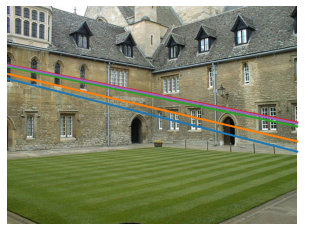

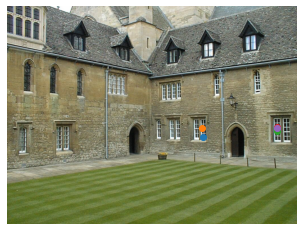

In [265]:
# index for points in first two views
ndx = (corr[:,0]>=0) & (corr[:,1]>=0)

# get coordinates and make homogeneous
x1 = points2D[0][:,corr[ndx,0]]
x1 = vstack( (x1,ones(x1.shape[1])) )
x2 = points2D[1][:,corr[ndx,1]]
x2 = vstack( (x2,ones(x2.shape[1])) )

# compute F
F = compute_fundamental(x1,x2)

# compute the epipole
e = compute_epipole(F)

# plotting
figure()
imshow(im1)

# plot each line individually, this gives nice colors
for i in range(5):
  plot_epipolar_line(im1,F,x2[:,i],e,False)
axis('off')
figure()
imshow(im2)
# plot each point individually, this gives same colors as the lines
for i in range(5):
  plot(x2[0,i],x2[1,i],'o')
axis('off')
show()

First, the points that are in correspondence between the two images are selected and made into homogeneous coordinates. Here we just read them from a text file; in reality these would be the result of extracting features and matching them as we did in our previous notebook. The missing values in the correspondence list corr are −1, so picking indices greater or equal to zero gives the points visible in each view. The two conditions are combined with the array operator &.

Finally, the first five of the epipolar lines are shown in the first view and the corresponding
matching points in view 2.

The plotting function for the epipolar lines parameterizes the line with the range of the x axis and removes parts of lines above and below the image border. If the last parameter show_epipole is true, the epipole will be plotted as well (and computed if not passed as input). The plots are shown above. The color coding matches between the plots so you can see that the corresponding point in one image lies somewhere along the same-color line as a point in the other image.

***Computing with cameras and 3D structure***

The previous section covered relationships between views and how to compute the fundamental matrix and epipolar lines. Here we briefly explain the tools we need for computing with cameras and 3D structure.

*Triangulation*

For two views with camera matrices $P_1$ and $P_2$, each with a projection $\mathbf{x}_1$ and $\mathbf{x}_2$ of the same 3D point $\mathbf{X}$ (all in homogeneous coordinates), the camera equation gives the relation

$$\left( \begin{array}{ccc} P_1 & -\mathbf{x}_1 & 0 \\ P_2 & 0 & -\mathbf{x}_2 \end{array} \right)
\left( \begin{array}{c} \mathbf{X} \\ \lambda_1 \\ \lambda_2 \end{array} \right) = \mathbf{0}$$

There might not be an exact solution to these equations due to image noise, errors in the camera matrices, or other sources of errors. Using SVD, we can get a least squares estimate of the 3D point.

The following function computes the least squares triangulation of a point pair.

In [266]:
def triangulate_point(x1,x2,P1,P2):
    """ Point pair triangulation from 
        least squares solution. """
        
    M = zeros((6,6))
    M[:3,:4] = P1
    M[3:,:4] = P2
    M[:3,4] = -x1
    M[3:,5] = -x2

    U,S,V = linalg.svd(M)
    X = V[-1,:4]

    return X / X[3]

The first four values in the last eigenvector are the 3D coordinates in homogeneous coordinates. To triangulate many points, we can add the following convenience function:

In [267]:
def triangulate(x1,x2,P1,P2):
    """    Two-view triangulation of points in 
        x1,x2 (3*n homog. coordinates). """
        
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    X = [ triangulate_point(x1[:,i],x2[:,i],P1,P2) for i in range(n)]
    return array(X).T

This function takes two arrays of points and returns an array of 3D coordinates.

Try the triangulation on the Merton1 data like this:

[[ 1.03743725  1.56125273  1.40720017]
 [-0.57574987 -0.55504127 -0.46523952]
 [ 3.44173797  3.44249282  7.53176488]
 [ 1.          1.          1.        ]]
[[ 1.0378863   1.5606923   1.4071907 ]
 [-0.54627892 -0.5211711  -0.46371818]
 [ 3.4601538   3.4636809   7.5323397 ]
 [ 1.          1.          1.        ]]


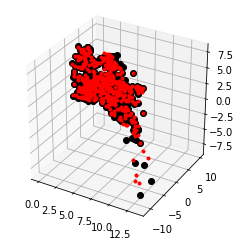

In [268]:
# index for points in first two views
ndx = (corr[:,0]>=0) & (corr[:,1]>=0)

# get coordinates and make homogeneous
x1 = points2D[0][:,corr[ndx,0]]
x1 = vstack( (x1,ones(x1.shape[1])) )
x2 = points2D[1][:,corr[ndx,1]]
x2 = vstack( (x2,ones(x2.shape[1])) )
Xtrue = points3D[:,ndx]
Xtrue = vstack( (Xtrue,ones(Xtrue.shape[1])) )

# check first 3 points
Xest = triangulate(x1,x2,P[0].P,P[1].P)
print(Xest[:,:3])
print(Xtrue[:,:3])

#plotting
from mpl_toolkits.mplot3d import axes3d
fig = figure()
ax = plt.axes(projection="3d")
ax.plot(Xest[0],Xest[1],Xest[2],'ko')
ax.plot(Xtrue[0],Xtrue[1],Xtrue[2],'r.')
ax.set_box_aspect(aspect = (1,1,1))
show()

This will triangulate the points in correspondence from the first two views and print out the coordinates of the first three points to the console before plotting the recovered 3D points next to the true values.

***Computing the Camera Matrix from 3D Points***

With known 3D points and their image projections, the camera matrix, $P$, can be computed using a direct linear transform approach. This is essentially the inverse problem to triangulation and is sometimes called camera resectioning. This way to recover the camera matrix is again a least squares approach.

From the camera equation, each visible 3D point $\mathbf{X}_i$ (in homogeneous coordinates) is projected to an image point $\mathbf{x}_i = \left( \begin{array}{ccc} x_i & y_i & 1 \end{array} \right)$ as $\lambda_i \mathbf{x}_i = P \mathbf{X}_i$ and the corresponding points satisfy the relation

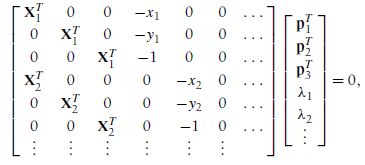

where $\mathbf{p}_1$, $\mathbf{p}_2$, and $\mathbf{p}_3$ are the three rows of $P$. This can be written more compactly as

$$M \mathbf{v} = \mathbf{0}$$

The estimation of the camera matrix is then obtained using SVD. With the matrices described above, the code is straightforward:

In [269]:
def compute_P(x,X):
    """    Compute camera matrix from pairs of
        2D-3D correspondences (in homog. coordinates). """

    n = x.shape[1]
    if X.shape[1] != n:
        raise ValueError("Number of points don't match.")
        
    # create matrix for DLT solution
    M = zeros((3*n,12+n))
    for i in range(n):
        M[3*i,0:4] = X[:,i]
        M[3*i+1,4:8] = X[:,i]
        M[3*i+2,8:12] = X[:,i]
        M[3*i:3*i+3,i+12] = -x[:,i]
        
    U,S,V = linalg.svd(M)
    
    return V[-1,:12].reshape((3,4))

This function takes the image points and 3D points and builds up the matrix $M$ above. The first 12 values of the last eigenvector are the elements of the camera matrix and are returned after a reshaping operation.

Again, let’s try this on our sample data set. The following script will pick out the points that are visible in the first view (using themissing values from the correspondence list), make them into homogeneous coordinates, and estimate the camera matrix:

[[ 1.06520794e+00 -5.23431275e+01  2.06902749e+01  5.08729305e+02]
 [-5.05773115e+01 -1.33243276e+01 -1.47388537e+01  4.79178838e+02]
 [ 3.05121915e-03 -3.19264684e-02 -3.43703738e-02  1.00000000e+00]]
[[ 1.06774679e+00 -5.23448212e+01  2.06926980e+01  5.08764487e+02]
 [-5.05834364e+01 -1.33201976e+01 -1.47406641e+01  4.79228998e+02]
 [ 3.06792659e-03 -3.19008054e-02 -3.43665129e-02  1.00000000e+00]]


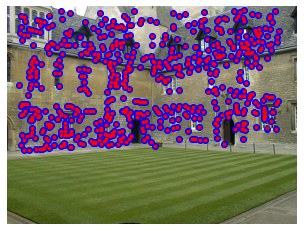

In [270]:
import sfm, camera

corr = corr[:,0] # view 1
ndx3D = where(corr>=0)[0] # missing values are -1
ndx2D = corr[ndx3D]

# select visible points and make homogeneous
x = points2D[0][:,ndx2D] # view 1
x = vstack( (x,ones(x.shape[1])) )
X = points3D[:,ndx3D]
X = vstack( (X,ones(X.shape[1])) )

# estimate P
Pest = camera.Camera(sfm.compute_P(x,X))
# compare!
print(Pest.P / Pest.P[2,3])
print(P[0].P / P[0].P[2,3])
xest = Pest.project(X)
# plotting
figure()
imshow(im1)
plot(x[0],x[1],'bo')
plot(xest[0],xest[1],'r.')
axis('off')
show()